In [52]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import physo

### Ramek utility functions

In [53]:

def make_callable_equation(eq_str: str, all_var_names: list[str]):
    """
    INPUTS:
    eq_str: a string containing the symbolic expression
        e.g. eq_str = "2*L_X + 5"
    all_var_names: list containing the name of all variables which need to be turned into
    dynamic callable objects
        e.g. all_var_names = ["L_X", "t_STAR"]

    OUTPUTS:
    f: an function which takes an input set of parameters and outputs the prediction
    """
    expr = eq_str.replace('^', '**').replace('atan', 'arctan')
    used_vars = [v for v in all_var_names
                 if re.search(rf"\b{re.escape(v)}\b", expr)]
    safe_dict = {
        'exp': np.exp,
        'log': np.log,
        'sin': np.sin,
        'tanh': np.tanh,
        'arctan': np.arctan,
        'abs': np.abs,
        'sinh': np.sinh,
        'cosh': np.cosh,
        'safe_sin': np.sin,
        'safe_log': np.log,
        'sqrt':np.sqrt
    }
    def f(args):
        vals = np.asarray(args)
        if vals.ndim != 1:
            raise ValueError('Input must be 1D array of values')
        local_vars = {v: vals[all_var_names.index(v)] for v in used_vars}
        return eval(expr, safe_dict, local_vars)
    f.all_var_names = all_var_names
    f.used_vars = used_vars
    return f

In [54]:

def data_plot_t21(
    csv_path,
    xhi_func,
    ts_func,
    all_var_names,
    omega_m,
    omega_b,
    h,
    n_curves=5,
    output_file=None
):
    """
    Plots model vs true 21cm brightness temperature using analytical xHI and Ts functions,
    and shows residuals in a separate subplot.

    Parameters:
    - csv_path: path to the CSV file
    - xhi_func: callable function that takes (args) and returns xHI
    - ts_func: callable function that takes (args) and returns Ts
    - all_var_names: list of all variable names (including 'z' and astro params)
    - omega_m, omega_b, h: cosmological parameters
    - n_curves: number of unique parameter sets to plot
    - output_file: optional path to save the plot
    """

    def T21(z, xHI, Ts):
        Tcmb = 2.725 * (1 + z)
        return (
            27.0 * xHI * (1 - Tcmb * Ts) * np.sqrt((1 + z) / 10.0)
            * np.sqrt(0.15 / (omega_m * h**2)) * (omega_b * h**2 / 0.023)
        )
    # Tcmb*Ts and not Tcmb/Ts because the Ts I input is actually 1/Ts
    df = pd.read_csv(csv_path)
    param_cols = [v for v in all_var_names if v != "z"]
    z_col = "z"
    Tb_col = "Tb"

    params_all = (
        df[param_cols]
        .drop_duplicates()
        .sample(n=n_curves, random_state=None)
        .to_numpy()
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(n_curves)]

    for i, (pset, color) in enumerate(zip(params_all, colors)):
        mask = (df[param_cols] == pset).all(axis=1)
        z_vals = df.loc[mask, z_col].values
        Tb_true = df.loc[mask, Tb_col].values

        Tb_model = []
        for z0 in z_vals:
            args = np.zeros(len(all_var_names))
            args[all_var_names.index("z")] = z0
            for name, val in zip(param_cols, pset):
                args[all_var_names.index(name)] = val
            xhi_val = xhi_func(args)
            ts_val = ts_func(args)
            Tb_model.append(T21(z0, xhi_val, ts_val))
        Tb_model = np.array(Tb_model)
        residuals = Tb_model - Tb_true

        ax1.plot(z_vals, Tb_true, '--', color=color, label=f'Curve {i+1} (true)')
        ax1.plot(z_vals, Tb_model, '-', color=color, label=f'Curve {i+1} (model)')
        ax2.plot(z_vals, residuals, '-', color=color, label=f'Residual {i+1}')

    #ax1.set_xlim(5, 20)
    #ax1.set_ylim(-180, 50)
    ax1.set_ylabel("Tb [mK]")
    ax1.set_title("Analytical Tb vs True Data")
    ax1.grid(True)
    #ax1.legend()

    ax2.set_xlabel("Redshift z")
    ax2.set_ylabel("Residuals [mK]")
    #ax2.set_xlim(5, 20)
    #ax2.set_ylim(-20, 20)
    ax2.grid(True)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)

    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"Plot saved to: {output_file}")
    else:
        plt.show()

In [55]:

def weighted_mse(f, data_csv_path, target_name, weight_func=None, weight_column=None, fraction=1.0):
    """
    Computes the (optionally weighted) MSE of f over a random subset of the dataset.

    Parameters:
    - f: callable from make_callable_equation (with .all_var_names)
    - data_csv_path: path to CSV file with header row including inputs and target
    - target_name: name of the target column
    - weight_func: optional function(df) -> weight array
    - weight_column: optional column in df to use as weights
    - fraction: float in (0, 1], percentage of data to randomly use
    """
    # Load data
    df = pd.read_csv(data_csv_path)
    cols = df.columns.tolist()
    if target_name not in cols:
        raise ValueError(f"Target '{target_name}' not in columns: {cols}")

    # Identify inputs
    all_vars = f.all_var_names
    input_cols = [c for c in all_vars if c in cols and c != target_name]
    data_present = df[input_cols].values
    y_true = df[target_name].values

    # Weights
    if weight_column and weight_column in df.columns:
        w = df[weight_column].values
    elif weight_func is not None:
        w = weight_func(df)
    else:
        w = np.ones_like(y_true, dtype=float)

    # Predictions
    y_pred = []
    for row in data_present:
        args_full = np.zeros(len(all_vars), dtype=float)
        for name, val in zip(input_cols, row):
            idx = all_vars.index(name)
            args_full[idx] = val
        y_pred.append(f(args_full))
    y_pred = np.array(y_pred)

    # Filter out invalid values
    valid_mask = np.isfinite(y_pred) & np.isfinite(y_true) & np.isfinite(w)
    num_invalid = np.sum(~valid_mask)
    if num_invalid > 0:
        print(f"[weighted_mse] Ignoring {num_invalid} invalid points (nan/inf)")

    y_pred = y_pred[valid_mask]
    y_true = y_true[valid_mask]
    w = w[valid_mask]

    # Subsample if fraction < 1.0
    if not (0 < fraction <= 1.0):
        raise ValueError("fraction must be in (0, 1]")
    if fraction < 1.0:
        rng = np.random.default_rng()
        n_total = len(y_true)
        n_sample = int(np.floor(fraction * n_total))
        indices = rng.choice(n_total, size=n_sample, replace=False)
        y_true = y_true[indices]
        y_pred = y_pred[indices]
        w = w[indices]

    # Return weighted MSE
    return np.average((y_true - y_pred) ** 2, weights=w), np.average(np.abs(y_true - y_pred), weights=w)


In [56]:

def inline_as_template(base: str) -> str:
    '''
    Replace exact symbols with {placeholders}, wrapped in parentheses
    Use word boundaries so we only hit whole tokens.
    '''
    base = re.sub(r"\bTs_peak\b", "{ts_peak_str}", base)
    base = re.sub(r"\bz_peak\b", "{z_peak_str}", base)
    base = base.replace("{ts_peak_str}", "({ts_peak_str})")
    base = base.replace("{z_peak_str}", "({z_peak_str})")
    return base

### Marek expressions

In [57]:

''' ---------- COMPARISONS ---------- '''

ALL_VARS = ["z", "F_STAR10", "F_ESC10", "ALPHA_STAR", "ALPHA_ESC", "M_TURN", "L_X","t_STAR"]

# Equation for xHI
xhi_str = "(((((safe_sin((tanh(safe_log((((((((safe_sin(M_TURN) * (((L_X * (ALPHA_STAR * 1.1799241)) * ((safe_sin(((F_STAR10 * 4.919791) + z) + (ALPHA_ESC / -1.0749326)) + ((-1.3243904 - safe_sin(M_TURN)) - F_STAR10)) * (ALPHA_ESC * F_STAR10))) + ((((safe_sin((z / F_ESC10) * exp(F_STAR10 / M_TURN)) * -3.3518918) + z) * exp((t_STAR / F_ESC10) - F_ESC10)) - -24.848547))) - (((M_TURN + (ALPHA_STAR * 8.117749)) * F_STAR10) * safe_sin((exp(F_ESC10) - F_ESC10) * ((z - F_STAR10) + (((-1.0749326 - ALPHA_STAR) - ((0.2743339 - (F_STAR10 + ALPHA_ESC)) ^ F_STAR10)) - F_STAR10))))) - (((F_STAR10 * 4.919791) - ((z / M_TURN) * (z / F_ESC10))) * (((M_TURN * ((F_STAR10 + ALPHA_STAR) - safe_sin(ALPHA_STAR + M_TURN))) + (F_ESC10 + z)) + (z * safe_sin(ALPHA_STAR))))) * -0.015924811) - safe_sin(M_TURN + 0.524485)) + ((-1.2934093 - (F_ESC10 * z)) + (ALPHA_ESC * ((z / 8.215435) + ((M_TURN * -0.7390863) + ((z - -0.023805484) - ((safe_sin(M_TURN + (ALPHA_STAR + ALPHA_STAR)) - ALPHA_ESC) * -3.107426))))))) - ((F_STAR10 * z) + 0.61098063)) * 0.09978405) / 0.364232) * 0.6278417) + 0.5048569) - -0.09439781) ^ 1.8367184) ^ 1.3174798) ^ 2.1265135) ^ 1.826374) + 0.0015122016"
xhi_func = make_callable_equation(xhi_str, ALL_VARS)

# Equation for 1/Ts for redshifts between 5 and 22
ts_str_low = "tanh((tanh(exp((((z - z_peak) * 0.07072452) * (M_TURN + safe_log(ALPHA_STAR))) + 0.7218971)) * (((((z ^ exp(F_STAR10)) + exp(z - ((17.859255 / ((M_TURN * safe_sin(L_X + (z - z_peak))) + (((z - z_peak) * (z + ((F_STAR10 * 1.0659447) - z_peak))) + (z_peak - 1.4324057)))) / 0.023255382))) ^ -0.1023375) * Ts_peak) - -0.71775156)) * ((((tanh(exp((((M_TURN + safe_sin((safe_log(M_TURN) * (ALPHA_STAR ^ F_ESC10)) + ((-1.0115682 - F_STAR10) - t_STAR))) * (z - z_peak)) * 0.067972824) + 0.7160633)) / ((M_TURN * 0.754901) + (exp(((ALPHA_STAR / ((M_TURN - safe_sin(((L_X + safe_log(z)) - (0.4569917 ^ F_ESC10)) * safe_log(M_TURN))) * ((((M_TURN + (((z_peak + -1.6376663) * ALPHA_STAR) * (safe_sin((z - z_peak) + (1.4041865 - M_TURN)) * -1.5259134))) - (ALPHA_STAR * z_peak)) / (M_TURN / ALPHA_STAR)) + ((z ^ Ts_peak) * safe_sin(M_TURN))))) ^ Ts_peak) + (M_TURN * ((z - z_peak) * 0.097844884))) - (((((z * exp(Ts_peak)) - safe_sin(Ts_peak ^ tanh(F_STAR10))) * -0.0553622) + (((z * Ts_peak) * (Ts_peak + 0.07072452)) * (safe_sin(M_TURN) / exp(safe_sin((((M_TURN * (z - z_peak)) * 0.097844884) - -0.59600586) + (M_TURN + L_X)))))) * safe_sin(z_peak))))) * Ts_peak) * 9.044627) + 0.022557778))"

# Extra equations to key features of 1/Ts fits which helped me get it to fit better
ts_peak_str = "((safe_sin(L_X * -0.412798) * -0.03789818) + 0.042685967) * ((ALPHA_STAR + M_TURN) + ((((((((F_STAR10 - (safe_log(t_STAR) * safe_sin(L_X * ((exp(M_TURN + (-2.5673013 - safe_sin(M_TURN / 0.5527258))) ^ F_STAR10) + 0.5190023)))) * safe_sin((ALPHA_STAR * ((F_STAR10 + safe_sin(M_TURN + t_STAR)) + tanh((ALPHA_STAR * ((((F_STAR10 + 1.2627524) / ((safe_sin(M_TURN + (t_STAR + (ALPHA_STAR * 1.3486092))) + 1.1601826) / ALPHA_STAR)) + F_ESC10) / -0.9210613)) ^ t_STAR))) - L_X)) * (1.7782724 / (safe_sin((safe_sin(L_X + (F_STAR10 - 5.8834844)) + -0.7619097) / -0.94500387) + F_STAR10))) + (((safe_sin(t_STAR) * (safe_sin(M_TURN) / (F_STAR10 - -0.7573181))) * safe_sin(L_X)) * safe_log(((0.90975463 ^ M_TURN) + tanh((ALPHA_ESC * ((((ALPHA_ESC + safe_sin(t_STAR / F_ESC10)) * -0.32353887) + safe_sin(L_X * -0.7573181)) + (ALPHA_STAR / -1.2603785))) - F_ESC10)) * ALPHA_STAR))) / tanh(((-0.6813579 / F_STAR10) ^ tanh(t_STAR)) + F_STAR10)) - -1.0541497) * (-0.9733955 - F_STAR10)) + t_STAR))"
z_peak_str = "(F_STAR10 + (((((((safe_sin(t_STAR) ^ 0.27041385) * -3.2950191) + (L_X + F_STAR10)) * 16.295452) + -477.81326) / ((M_TURN + (ALPHA_STAR * 3.1855927)) - safe_sin(safe_sin((F_STAR10 * ALPHA_STAR) + M_TURN)))) + (ALPHA_STAR + ALPHA_STAR))) - (((tanh(safe_sin(safe_log(tanh(-0.6478873 / F_STAR10)) + ((M_TURN + M_TURN) + (t_STAR - L_X)))) + (((-1.9133488 / ((F_STAR10 * 0.2556071) - t_STAR)) * (safe_sin((((L_X + ((ALPHA_STAR + safe_sin((ALPHA_ESC * 1.3293012) + M_TURN)) * (t_STAR * (F_ESC10 - ALPHA_ESC)))) + F_STAR10) + -2.2501333) / -0.56212574) / ALPHA_STAR)) / (M_TURN - ((safe_sin(safe_sin(F_STAR10) * ((M_TURN - -0.2534935) * exp(ALPHA_STAR))) + F_ESC10) * 1.3223152)))) - tanh(F_ESC10 - ALPHA_ESC)) / ((M_TURN * 0.9857466) + (((safe_sin(((F_STAR10 / (ALPHA_STAR - 1.9287828)) + M_TURN) + (ALPHA_ESC * exp(-0.6894717))) * safe_log((ALPHA_ESC - -2.6539373) * ALPHA_STAR)) * -11.081027) + ((((ALPHA_STAR + -1.754012) - F_STAR10) / (F_ESC10 * (F_STAR10 * (ALPHA_STAR * F_STAR10)))) / ALPHA_STAR))))"

# Inserting those extra equations into the Ts fit, so it depends directly on astro parameters
ts_str_low_template = inline_as_template(ts_str_low)
ts_str_low = ts_str_low_template.format(ts_peak_str=ts_peak_str,z_peak_str=z_peak_str)

# 1/Ts fit for redshifts 16 to 50
ts_str_high = "(((ALPHA_STAR ^ F_STAR10) / (t_STAR * (exp(z - (-4.1358356 / F_STAR10)) / L_X))) / exp(z * (-0.21714371 * safe_sin(M_TURN)))) + (((1.3296173 / z) / (z * 0.38624322)) + 0.008983023)"

# Merge the low and high redshift expressions
ts_str = f"(1 - 0.5 * (1 + tanh(1 * (z - 16)))) * ({ts_str_low}) + " \
         f"(0.5 * (1 + tanh(1 * (z - 16)))) * ({ts_str_high})"
ts_func = make_callable_equation(ts_str, ALL_VARS)

omega_m=0.315
omega_b=0.0486
h=0.674
target_var = "Tb"

# Build the final Tb expression
t21_expr = f"27 * ({xhi_str}) * (1 - 2.725 * (1 + z) * ({ts_str})) *sqrt((1 + z)/10.0) * sqrt(0.15 / ({omega_m} * {h}**2)) *({omega_b} * {h}**2 / 0.023)"
print(t21_expr)
f = make_callable_equation(t21_expr, ALL_VARS)

27 * ((((((safe_sin((tanh(safe_log((((((((safe_sin(M_TURN) * (((L_X * (ALPHA_STAR * 1.1799241)) * ((safe_sin(((F_STAR10 * 4.919791) + z) + (ALPHA_ESC / -1.0749326)) + ((-1.3243904 - safe_sin(M_TURN)) - F_STAR10)) * (ALPHA_ESC * F_STAR10))) + ((((safe_sin((z / F_ESC10) * exp(F_STAR10 / M_TURN)) * -3.3518918) + z) * exp((t_STAR / F_ESC10) - F_ESC10)) - -24.848547))) - (((M_TURN + (ALPHA_STAR * 8.117749)) * F_STAR10) * safe_sin((exp(F_ESC10) - F_ESC10) * ((z - F_STAR10) + (((-1.0749326 - ALPHA_STAR) - ((0.2743339 - (F_STAR10 + ALPHA_ESC)) ^ F_STAR10)) - F_STAR10))))) - (((F_STAR10 * 4.919791) - ((z / M_TURN) * (z / F_ESC10))) * (((M_TURN * ((F_STAR10 + ALPHA_STAR) - safe_sin(ALPHA_STAR + M_TURN))) + (F_ESC10 + z)) + (z * safe_sin(ALPHA_STAR))))) * -0.015924811) - safe_sin(M_TURN + 0.524485)) + ((-1.2934093 - (F_ESC10 * z)) + (ALPHA_ESC * ((z / 8.215435) + ((M_TURN * -0.7390863) + ((z - -0.023805484) - ((safe_sin(M_TURN + (ALPHA_STAR + ALPHA_STAR)) - ALPHA_ESC) * -3.107426))))))) - ((F_STA

Plot saved to: Tb-Training-Fit.png
Plot saved to: Tb-Test-Fit.png
128 curves (training set) weighted MSE: 1.6917165470726463
128 curves (training set) weighted RMSE: 1.3006600428523383
128 curves (training set) weighted MAE: 0.8549120857305398


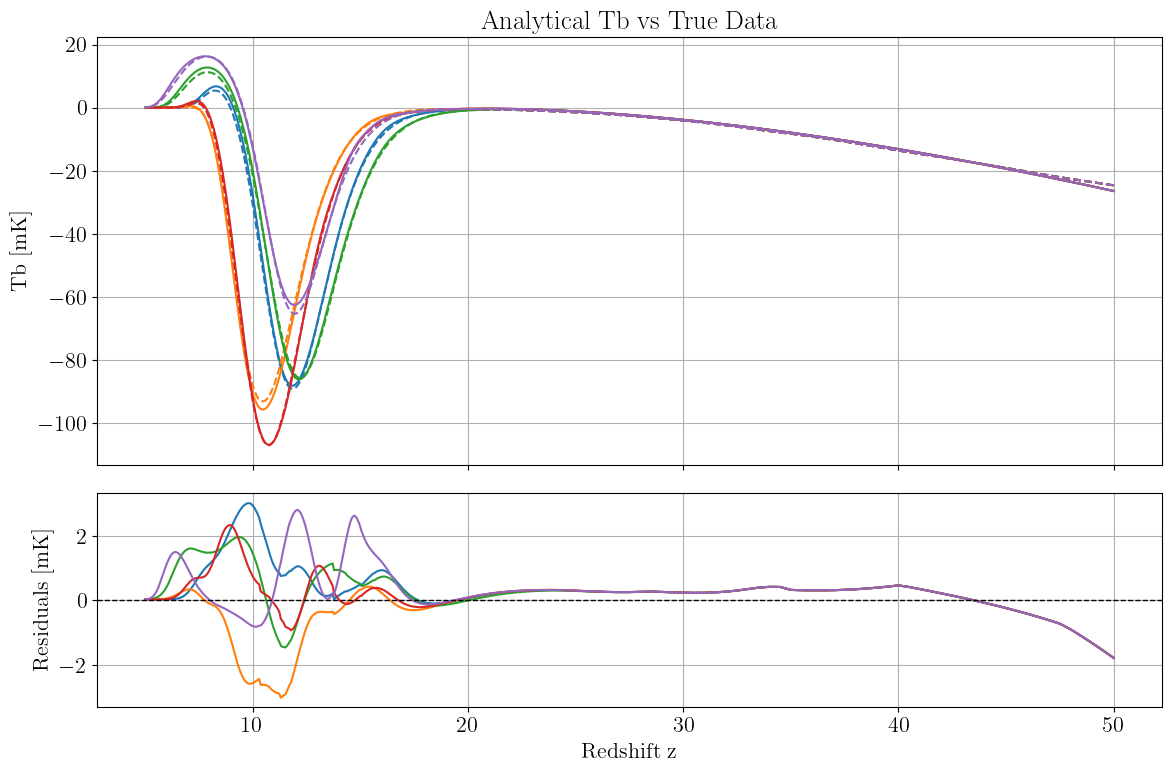

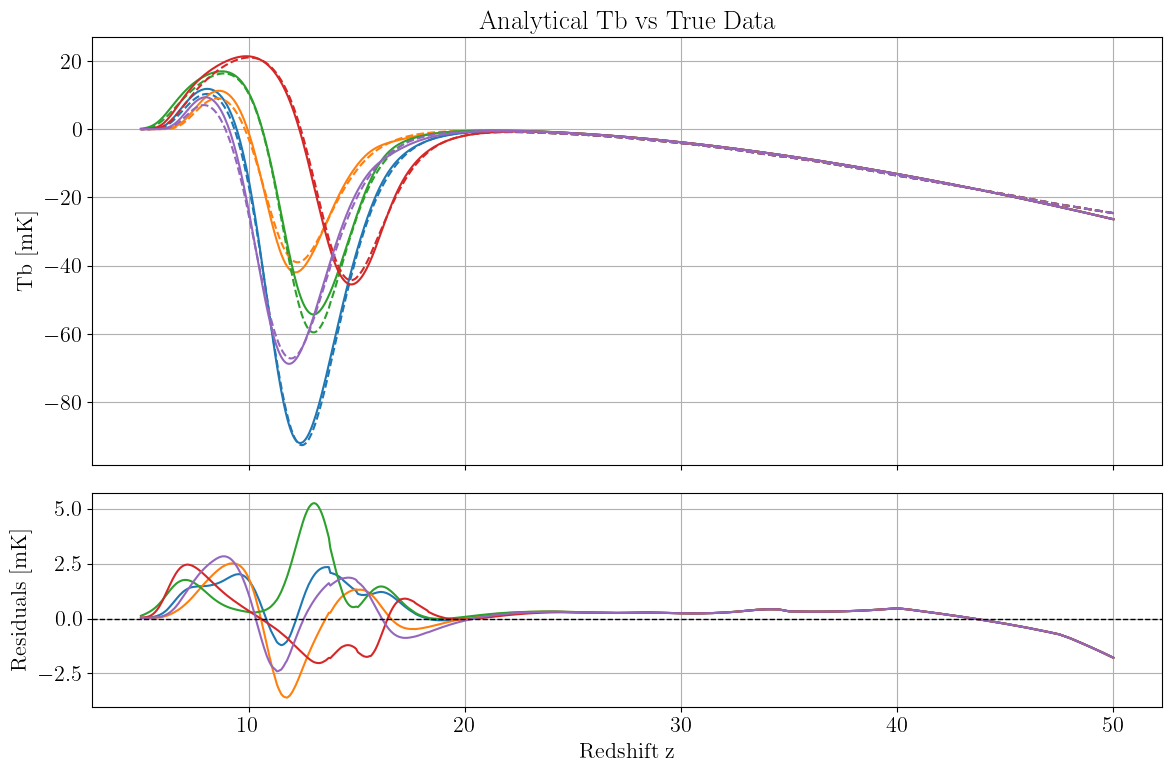

In [58]:

''' ---------- PLOTTING RESULTS & MSE ---------- '''
data_plot_t21(
    csv_path="128_curves.csv",
    xhi_func=xhi_func,
    ts_func=ts_func,
    all_var_names=ALL_VARS,
    omega_m=0.315,
    omega_b=0.0486,
    h=0.674,
    n_curves=5,
    output_file="Tb-Training-Fit.png"
)

data_plot_t21(
    csv_path="4096_curves.csv",
    xhi_func=xhi_func,
    ts_func=ts_func,
    all_var_names=ALL_VARS,
    omega_m=0.315,
    omega_b=0.0486,
    h=0.674,
    n_curves=5,
    output_file="Tb-Test-Fit.png"
)

mse, mae = weighted_mse(
    f=f,
    data_csv_path="128_curves.csv",
    target_name=target_var,
    weight_func=lambda df: 0.5 * (1 - np.tanh(10 * (df["z"] - 22)))
)

print("128 curves (training set) weighted MSE:", mse)
print("128 curves (training set) weighted RMSE:", np.sqrt(mse))
print("128 curves (training set) weighted MAE:", mae)

#''' Takes a long time to run
#mse, mae = weighted_mse(
#    f=f,
#    data_csv_path="4096_curves.csv",
#    target_name=target_var,
#    weight_func=lambda df: 0.5 * (1 - np.tanh(10 * (df["z"] - 22)))
#)
#
#print("4096 curves (test set) weighted MSE:", mse)
#print("4096 curves (test set) weighted RMSE:", np.sqrt(mse))
#print("4096 curves (training set) weighted MAE:", mae)
#'''

### PhySO expressions

#### xHI

In [59]:

''' ---------- COMPARISONS ---------- '''

ALL_VARS = ["z", "F_STAR10", "F_ESC10", "ALPHA_STAR", "ALPHA_ESC", "M_TURN", "L_X","t_STAR"]

# Equation for xHI
xhi_str = "(((((safe_sin((tanh(safe_log((((((((safe_sin(M_TURN) * (((L_X * (ALPHA_STAR * 1.1799241)) * ((safe_sin(((F_STAR10 * 4.919791) + z) + (ALPHA_ESC / -1.0749326)) + ((-1.3243904 - safe_sin(M_TURN)) - F_STAR10)) * (ALPHA_ESC * F_STAR10))) + ((((safe_sin((z / F_ESC10) * exp(F_STAR10 / M_TURN)) * -3.3518918) + z) * exp((t_STAR / F_ESC10) - F_ESC10)) - -24.848547))) - (((M_TURN + (ALPHA_STAR * 8.117749)) * F_STAR10) * safe_sin((exp(F_ESC10) - F_ESC10) * ((z - F_STAR10) + (((-1.0749326 - ALPHA_STAR) - ((0.2743339 - (F_STAR10 + ALPHA_ESC)) ^ F_STAR10)) - F_STAR10))))) - (((F_STAR10 * 4.919791) - ((z / M_TURN) * (z / F_ESC10))) * (((M_TURN * ((F_STAR10 + ALPHA_STAR) - safe_sin(ALPHA_STAR + M_TURN))) + (F_ESC10 + z)) + (z * safe_sin(ALPHA_STAR))))) * -0.015924811) - safe_sin(M_TURN + 0.524485)) + ((-1.2934093 - (F_ESC10 * z)) + (ALPHA_ESC * ((z / 8.215435) + ((M_TURN * -0.7390863) + ((z - -0.023805484) - ((safe_sin(M_TURN + (ALPHA_STAR + ALPHA_STAR)) - ALPHA_ESC) * -3.107426))))))) - ((F_STAR10 * z) + 0.61098063)) * 0.09978405) / 0.364232) * 0.6278417) + 0.5048569) - -0.09439781) ^ 1.8367184) ^ 1.3174798) ^ 2.1265135) ^ 1.826374) + 0.0015122016"
xhi_func = make_callable_equation(xhi_str, ALL_VARS)
xhi_func

<function __main__.make_callable_equation.<locals>.f(args)>

#### Ts

In [60]:
shorter_names = {
    "z": "z",
    "F_STAR10": "Fs",
    "F_ESC10": "Fesc",
    "ALPHA_STAR": "As",
    "ALPHA_ESC": "Aesc",
    "M_TURN": "Mt",
    "L_X": "LX",
    "t_STAR": "taus",
    "xHI": "xHI",
    "Ts": "Ts",
    "Tb": "Tb"
}
longer_names = {v: k for k, v in shorter_names.items()}

In [72]:
run_name = "run2"

In [73]:
# Loading
import physo
import physo.benchmark.utils.symbolic_utils as su

physo_Ts_pareto_csv = "/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/science/reionization-stellar-evolution/%s_Ts_curves_pareto.csv"%(run_name)
physo_Ts_pareto_pkl = "/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/science/reionization-stellar-evolution/%s_Ts_curves_pareto.pkl"%(run_name)
expr = physo.read_pareto_pkl(physo_Ts_pareto_pkl)[-1]
expr.get_infix_image(do_simplify = True, fpath="%s_Ts_expr.png"%(run_name))
expr_1_Ts = expr.get_infix_sympy(evaluate_consts=False) # sympy expr
display(expr_1_Ts)
expr_1_Ts = expr.get_infix_sympy(evaluate_consts=True)[0] # sympy expr
display(expr_1_Ts)

# Replacing variable names in expr_1_Ts to match ALL_VARS with sympy.subs
expr_1_Ts = expr_1_Ts.subs(longer_names)
expr_1_Ts = str(expr_1_Ts)


(-c9)/(c8 - (LX*c3/(LX + c1 + c1 + c2 + c2 + c5 + c7 + z + z + z + (LX*z/(LX + c1 + c1 + c7 + c7 + c8) + c6 + z)/z + z/z) - c1 + c4 + c5 - c6 + c7 + 7*z))

-1.12291756467552/(-11.0484631508746*LX/(LX + 3*z - 50.3766465356726 + (LX*z/(LX - 43.3389233440272) + z + 18.2162990083916)/z + z/z) - 7*z + 99.7991135544148)

In [74]:
ts_str = expr_1_Ts
ts_func = make_callable_equation(ts_str, ALL_VARS)


In [64]:

# Merge the low and high redshift expressions




#### Tb

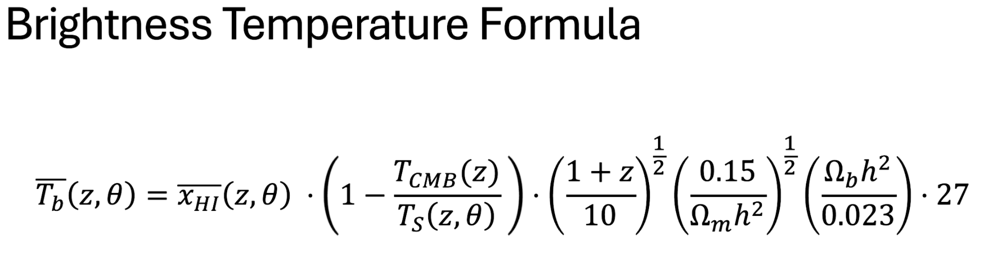

In [75]:
omega_m=0.315
omega_b=0.0486
h=0.674
target_var = "Tb"

# Build the final Tb expression
t21_expr = f"27 * ({xhi_str}) * (1 - 2.725 * (1 + z) * ({ts_str})) *sqrt((1 + z)/10.0) * sqrt(0.15 / ({omega_m} * {h}**2)) *({omega_b} * {h}**2 / 0.023)"
print(t21_expr)
f = make_callable_equation(t21_expr, ALL_VARS)

27 * ((((((safe_sin((tanh(safe_log((((((((safe_sin(M_TURN) * (((L_X * (ALPHA_STAR * 1.1799241)) * ((safe_sin(((F_STAR10 * 4.919791) + z) + (ALPHA_ESC / -1.0749326)) + ((-1.3243904 - safe_sin(M_TURN)) - F_STAR10)) * (ALPHA_ESC * F_STAR10))) + ((((safe_sin((z / F_ESC10) * exp(F_STAR10 / M_TURN)) * -3.3518918) + z) * exp((t_STAR / F_ESC10) - F_ESC10)) - -24.848547))) - (((M_TURN + (ALPHA_STAR * 8.117749)) * F_STAR10) * safe_sin((exp(F_ESC10) - F_ESC10) * ((z - F_STAR10) + (((-1.0749326 - ALPHA_STAR) - ((0.2743339 - (F_STAR10 + ALPHA_ESC)) ^ F_STAR10)) - F_STAR10))))) - (((F_STAR10 * 4.919791) - ((z / M_TURN) * (z / F_ESC10))) * (((M_TURN * ((F_STAR10 + ALPHA_STAR) - safe_sin(ALPHA_STAR + M_TURN))) + (F_ESC10 + z)) + (z * safe_sin(ALPHA_STAR))))) * -0.015924811) - safe_sin(M_TURN + 0.524485)) + ((-1.2934093 - (F_ESC10 * z)) + (ALPHA_ESC * ((z / 8.215435) + ((M_TURN * -0.7390863) + ((z - -0.023805484) - ((safe_sin(M_TURN + (ALPHA_STAR + ALPHA_STAR)) - ALPHA_ESC) * -3.107426))))))) - ((F_STA

#### Results

Plot saved to: run2_Tb-Training-Fit.png
Plot saved to: run2_Tb-Test-Fit.png
128 curves (training set) weighted MSE: 194.75705363078058
128 curves (training set) weighted RMSE: 13.95553845721406
128 curves (training set) weighted MAE: 10.401617434358396


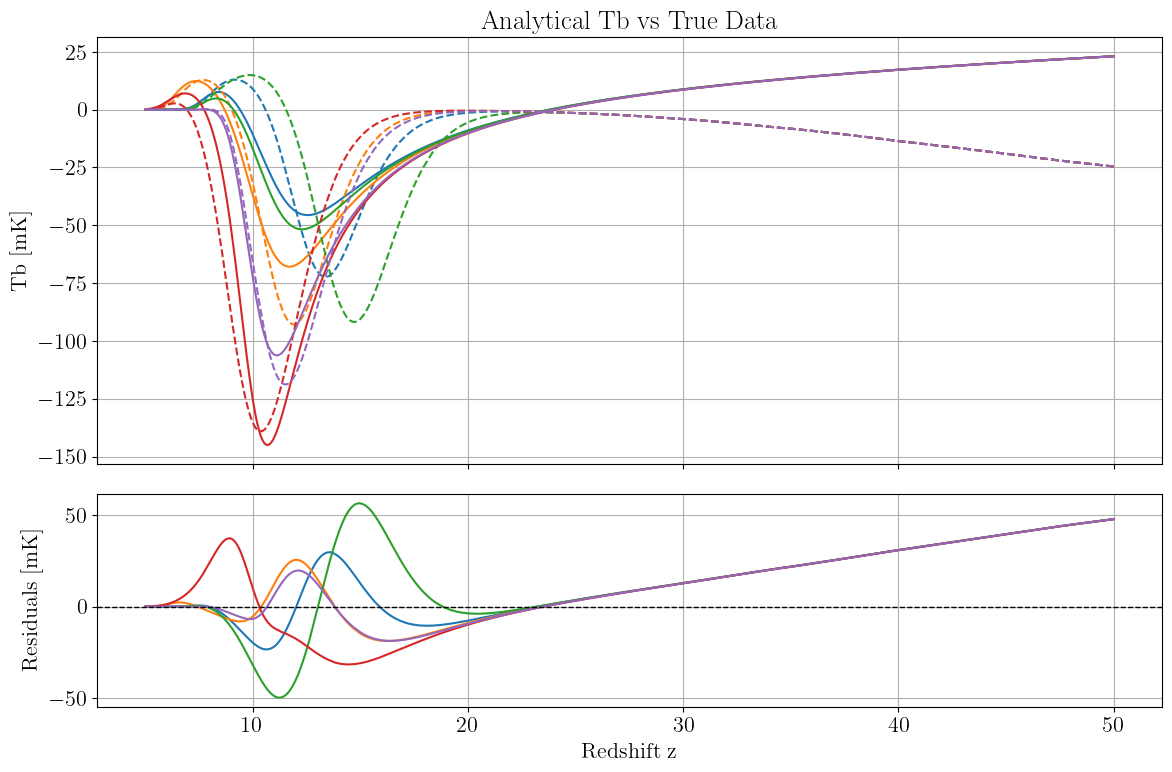

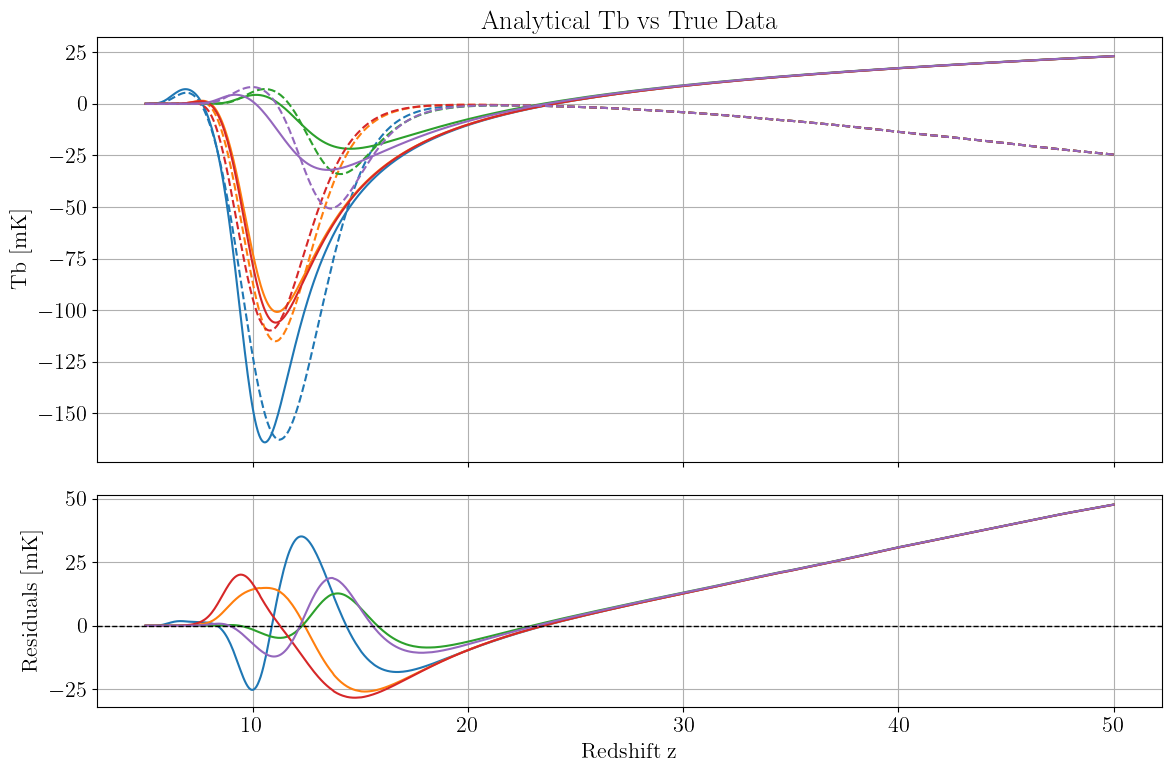

In [76]:

''' ---------- PLOTTING RESULTS & MSE ---------- '''
data_plot_t21(
    csv_path="128_curves.csv",
    xhi_func=xhi_func,
    ts_func=ts_func,
    all_var_names=ALL_VARS,
    omega_m=0.315,
    omega_b=0.0486,
    h=0.674,
    n_curves=5,
    output_file="%s_Tb-Training-Fit.png"%(run_name)
)

data_plot_t21(
    csv_path="4096_curves.csv",
    xhi_func=xhi_func,
    ts_func=ts_func,
    all_var_names=ALL_VARS,
    omega_m=0.315,
    omega_b=0.0486,
    h=0.674,
    n_curves=5,
    output_file="%s_Tb-Test-Fit.png"%(run_name)
)

mse, mae = weighted_mse(
    f=f,
    data_csv_path="128_curves.csv",
    target_name=target_var,
    weight_func=lambda df: 0.5 * (1 - np.tanh(10 * (df["z"] - 22)))
)

print("128 curves (training set) weighted MSE:", mse)
print("128 curves (training set) weighted RMSE:", np.sqrt(mse))
print("128 curves (training set) weighted MAE:", mae)

#''' Takes a long time to run
#mse, mae = weighted_mse(
#    f=f,
#    data_csv_path="4096_curves.csv",
#    target_name=target_var,
#    weight_func=lambda df: 0.5 * (1 - np.tanh(10 * (df["z"] - 22)))
#)
#
#print("4096 curves (test set) weighted MSE:", mse)
#print("4096 curves (test set) weighted RMSE:", np.sqrt(mse))
#print("4096 curves (training set) weighted MAE:", mae)
#'''